## Goals
- find similar companies and plot their returns
- find why they are different/similar in returns 

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import json
import re
import string
import nltk

In [3]:
df = pd.read_csv('preprocessed.csv')
df.drop_duplicates(subset = "name", keep=False, inplace=True)
df

,Unnamed: 0,accessionNumber,filingDate,reportingDate,financialEntity,htmlFile,coDescription,CIK,name,countryinc,cityma,SIC,SIC_desc,coDescription_lemmatized,coDescription_stopwords
0,0,0001441816-18-000028,2018-03-30 20:12:23 UTC,2018-02-01,financialEntities/params;cik=1441816,https://www.sec.gov/Archives/edgar/data/144181...,"mongodb is the leading modern, general purpose...",1441816,"MONGODB, INC.",US,NEW YORK,7372,Prepackaged Software (mass reproduction of sof...,"mongodb is the leading modern , general purpos...",mongodb leading modern general purpose databas...
1,1,0001108524-18-000011,2018-03-09 22:01:46 UTC,2018-02-01,financialEntities/params;cik=1108524,https://www.sec.gov/Archives/edgar/data/110852...,salesforce is a global leader in customer rela...,1108524,SALESFORCE COM INC,US,SAN FRANCISCO,7372,Prepackaged Software (mass reproduction of sof...,salesforce is a global leader in customer rela...,salesforce global leader customer relationship...
2,3,0001353283-18-000004,2018-03-30 21:21:46 UTC,2018-02-01,financialEntities/params;cik=1353283,https://www.sec.gov/Archives/edgar/data/135328...,splunk provides innovative software solutions ...,1353283,SPLUNK INC,NaN,SAN FRANCISCO,7372,Prepackaged Software (mass reproduction of sof...,splunk provides innovative software solution t...,splunk provides innovative software solution e...
3,4,0001660134-18-000007,2018-03-12 20:45:43 UTC,2018-02-01,financialEntities/params;cik=1660134,https://www.sec.gov/Archives/edgar/data/166013...,okta is the leading independent provider of id...,1660134,"OKTA, INC.",US,SAN FRANCISCO,7372,Prepackaged Software (mass reproduction of sof...,okta is the leading independent provider of id...,okta leading independent provider identity ent...
4,5,0001564590-18-007164,2018-03-29 21:34:05 UTC,2018-02-01,financialEntities/params;cik=1393052,https://www.sec.gov/Archives/edgar/data/139305...,veeva is a leading provider of industry cloud ...,1393052,VEEVA SYSTEMS INC,NaN,PLEASANTON,7372,Prepackaged Software (mass reproduction of sof...,veeva is a leading provider of industry cloud ...,veeva leading provider industry cloud solution...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,1114,0001595527-19-000005,2019-03-15 12:45:38 UTC,2019-01-01,financialEntities/params;cik=1595527,https://www.sec.gov/Archives/edgar/data/159552...,"ationwe were incorporated on december 19, 2013...",1595527,"AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.",US,NEW YORK,6798,Real Estate Investment Trusts,"ationwe were incorporated on december 19 , 201...",ationwe incorporated december maryland corpora...
671,1115,0001144204-19-016652,2019-03-28 20:28:30 UTC,2019-01-01,financialEntities/params;cik=1130166,https://www.sec.gov/Archives/edgar/data/113016...,llowing business section contains forward-look...,1130166,"CYCLACEL PHARMACEUTICALS, INC.",US,BERKELEY HEIGHTS,2834,Pharmaceutical Preparations,llowing business section contains forward-look...,llowing business section contains statement ac...
672,1117,0001555280-19-000041,2019-02-14 22:08:33 UTC,2019-01-01,financialEntities/params;cik=1555280,https://www.sec.gov/Archives/edgar/data/155528...,ts.costs and expenses costs of sales consist p...,1555280,ZOETIS INC.,NaN,PARSIPPANY,2834,Pharmaceutical Preparations,ts.costs and expense cost of sale consist prim...,expense cost sale consist primarily cost mater...
673,1121,0001479094-19-000006,2019-02-13 21:22:54 UTC,2019-01-01,financialEntities/params;cik=1479094,https://www.sec.gov/Archives/edgar/data/147909...,certain definitionsin this report:we define ga...,1479094,"STAG INDUSTRIAL, INC.",NaN,BOSTON,6798,Real Estate Investment Trusts,certain definitionsin this report : we define ...,certain definitionsin report define gaap gener...


In [4]:
embedding_matrix = pd.read_csv('embeddings.csv', index_col=0)

In [5]:
dot_product= np.matmul(embedding_matrix, embedding_matrix.T)
np.fill_diagonal(dot_product.values, 0)
dot_product.columns = dot_product.index
dot_product

C:\Users\maryx\AppData\Local\Temp\ipykernel_20140\2510848462.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  dot_product= np.matmul(embedding_matrix, embedding_matrix.T)


name,"MONGODB, INC.",SALESFORCE COM INC,SPLUNK INC,"OKTA, INC.",VEEVA SYSTEMS INC,AUTODESK INC,"INTERNATIONAL WESTERN PETROLEUM, INC.","DAYBREAK OIL & GAS, INC.",ULURU INC.,GB SCIENCES INC,...,OMEGA HEALTHCARE INVESTORS INC,TABLEAU SOFTWARE INC,HORIZON PHARMA PLC,MERRIMACK PHARMACEUTICALS INC,"REVEN HOUSING REIT, INC.","AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.","CYCLACEL PHARMACEUTICALS, INC.",ZOETIS INC.,"STAG INDUSTRIAL, INC.",EQUINIX INC
name,,,,,,,,,,,,,,,,,,,,,
"MONGODB, INC.",0.000000,0.803545,0.762206,0.818557,0.506437,0.573250,0.398757,0.373033,0.366619,0.410112,...,0.312144,0.760278,0.441694,0.338766,0.462890,0.401974,0.345887,0.369873,0.405723,0.707137
SALESFORCE COM INC,0.803545,0.000000,0.754499,0.821778,0.528720,0.632697,0.396002,0.419564,0.437798,0.442303,...,0.308415,0.783024,0.456251,0.391346,0.462356,0.399713,0.401082,0.347964,0.382198,0.761323
SPLUNK INC,0.762206,0.754499,0.000000,0.764913,0.516301,0.610626,0.402757,0.384544,0.394238,0.400018,...,0.325082,0.771398,0.424349,0.353091,0.445080,0.397698,0.362843,0.364976,0.393438,0.677133
"OKTA, INC.",0.818557,0.821778,0.764913,0.000000,0.488678,0.583515,0.370960,0.336968,0.393476,0.422685,...,0.296816,0.748318,0.412305,0.370430,0.468216,0.395530,0.379961,0.336927,0.406437,0.729258
VEEVA SYSTEMS INC,0.506437,0.528720,0.516301,0.488678,0.000000,0.438113,0.489709,0.618458,0.579144,0.532087,...,0.635305,0.489313,0.494291,0.518215,0.582004,0.643750,0.446102,0.753889,0.634775,0.446751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.",0.401974,0.399713,0.397698,0.395530,0.643750,0.376274,0.567591,0.599277,0.439046,0.491839,...,0.672912,0.386316,0.428253,0.408539,0.781276,0.000000,0.404900,0.568018,0.799552,0.400756
"CYCLACEL PHARMACEUTICALS, INC.",0.345887,0.401082,0.362843,0.379961,0.446102,0.356614,0.422619,0.441194,0.692019,0.651759,...,0.422453,0.395607,0.718162,0.764669,0.373852,0.404900,0.000000,0.409630,0.427925,0.387371
ZOETIS INC.,0.369873,0.347964,0.364976,0.336927,0.753889,0.328496,0.482264,0.549683,0.481188,0.491164,...,0.577152,0.346856,0.442694,0.431803,0.539115,0.568018,0.409630,0.000000,0.575564,0.316817


In [6]:
returns = pd.read_csv('returns_2018_top5_SIC.csv')
returns["Year"] =  returns["DATE"].apply(lambda x: x.split("-")[0])
returns["Month"] =  returns["DATE"].apply(lambda x: x.split("-")[1])
returns = returns[returns["Year"] == "2018"]

C:\Users\maryx\AppData\Local\Temp\ipykernel_20140\2146123554.py:8: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.plot(c["Month"], c["trt1m"], label=df.iloc[i].name, linewidth=1)


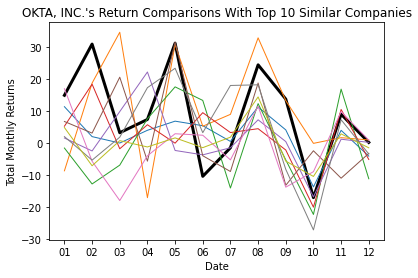

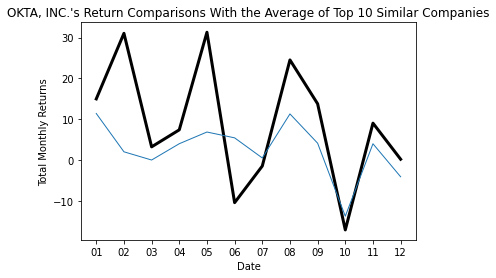

In [11]:
import matplotlib.pyplot as plt
def plotSimilar(company,n_similar):
    df = pd.DataFrame(dot_product[company].nlargest(n=n_similar))
    currentCompany = returns[returns["name"] == company]
    plt.plot(currentCompany["Month"], currentCompany["trt1m"], color="black",label=company, linewidth=3)
    for i in range(n_similar):
        c = returns[returns["name"] == df.iloc[i].name]
        plt.plot(c["Month"], c["trt1m"], label=df.iloc[i].name, linewidth=1)
    plt.title(company + "'s Return Comparisons With Top 10 Similar Companies")
    plt.xlabel('Date')
    plt.ylabel('Total Monthly Returns')
#     plt.legend()
    plt.show()
    
def plotAverage(company,n_similar):
    df = pd.DataFrame(dot_product[company].nlargest(n=n_similar))
    currentCompany = returns[returns["name"] == company]
    plt.plot(currentCompany["Month"], currentCompany["trt1m"], color="black",label=company, linewidth=3)
    average = pd.DataFrame()
    for i in range(n_similar):
        c = returns[returns["name"] == df.iloc[i].name]
        average[df.iloc[i].name] =c["trt1m"]
    average["mean"] = average.mean(axis=1)
    plt.plot(currentCompany["Month"], average["mean"], label="Average", linewidth=1)
    plt.title(company + "'s Return Comparisons With the Average of Top 10 Similar Companies")
    plt.xlabel('Date')
    plt.ylabel('Total Monthly Returns')
#     plt.legend()
    plt.show()
    
plotSimilar("OKTA, INC.", 10)
plotAverage("OKTA, INC.", 10)

In [19]:
import matplotlib.pyplot as plt
def findSimilar(company,n_similar):
    df = pd.DataFrame(dot_product[company].nlargest(n=n_similar))
    currentCompany = returns[returns["name"] == company].reset_index()
    sst = []
    for i in range(n_similar):
        c = returns[returns["name"] == df.iloc[i].name].reset_index()
        sst.append(np.sum((c["trt1m"]-currentCompany["trt1m"])**2))
    df["sum of squared differences"] = sst
    return df

similar = findSimilar("OKTA, INC.", 20)
similar = similar.merge(df, left_index=True, right_on='name')
similar.index = similar["name"]
similar = similar[["OKTA, INC.", "sum of squared differences", "SIC_desc"]]
##companies without returns data
similar["sum of squared differences"] = similar["sum of squared differences"].replace(0, np.nan)
similar

,"OKTA, INC.",sum of squared differences,SIC_desc
name,,,
SALESFORCE COM INC,0.821778,2048.069480,Prepackaged Software (mass reproduction of sof...
"MONGODB, INC.",0.818557,3070.791513,Prepackaged Software (mass reproduction of sof...
APPIAN CORP,0.818493,3935.494083,Prepackaged Software (mass reproduction of sof...
"QUALYS, INC.",0.815745,2372.958685,Prepackaged Software (mass reproduction of sof...
COMMVAULT SYSTEMS INC,0.801781,3271.945799,Prepackaged Software (mass reproduction of sof...
"UPLAND SOFTWARE, INC.",0.782920,2804.129571,Prepackaged Software (mass reproduction of sof...
PROGRESS SOFTWARE CORP /MA,0.781933,3908.802588,Prepackaged Software (mass reproduction of sof...
APPFOLIO INC,0.771396,2859.791013,Prepackaged Software (mass reproduction of sof...
MICROSTRATEGY INC,0.769307,3168.421202,Prepackaged Software (mass reproduction of sof...


In [22]:
#Company Z-Scaler is not in this set of data
df[df["CIK"] == 1713683]

,Unnamed: 0,accessionNumber,filingDate,reportingDate,financialEntity,htmlFile,coDescription,CIK,name,countryinc,cityma,SIC,SIC_desc,coDescription_lemmatized,coDescription_stopwords


## Top Words Using TF-IDF

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

doc = CountVectorizer(ngram_range=(1,4))
word_count=doc.fit_transform(df["coDescription_stopwords"])

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=doc.get_feature_names(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights']).head(40)

tf_idf_vector=tfidf_transformer.transform(word_count)
feature_names = doc.get_feature_names()

C:\Users\maryx\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\maryx\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
def getImportantWords(company_index):
    first_document_vector=tf_idf_vector[company_index]
    temp = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
    return temp.sort_values(by=["tfidf"],ascending=False).head(45)

In [29]:
## Get index of APPIAN, OKTA, SALESFORCE
##  OKTA AND SALESFORCE HAVE SIMILAR RETURNS IN 2018
## APPIAN AND OKTA HAVE DISSIMILAR RETURNS IN 2018

def getIndex(companyName):
    condition = df["name"] == companyName
    index = df.index
    return index[condition].tolist()

OKTA = getIndex("OKTA, INC.")[0]
APPIAN = getIndex("APPIAN CORP")[0]
SALESFORCE = getIndex("SALESFORCE COM INC")[0]

In [30]:
getImportantWords(OKTA)

,tfidf
okta,0.372357
okta identity,0.248238
identity cloud,0.240481
okta identity cloud,0.232723
identity,0.224563
cloud,0.222241
customer,0.124010
user,0.107594
platform,0.073239
application,0.066421


In [45]:
#Weird behaviour here
getImportantWords(APPIAN)
# df[df["name"]  == "APPIAN CORP"]

,tfidf
natural gas,0.169664
oil natural gas,0.167524
oil natural,0.167524
general partner,0.161342
gas,0.152709
dorchester,0.145394
oil,0.144145
gp party,0.130907
dorchester mineral,0.130907
natural,0.115310


In [31]:
getImportantWords(SALESFORCE)

,tfidf
cloud,0.223693
customer,0.182213
apps,0.139078
salesforce,0.127748
service,0.121460
subscription,0.095971
platform,0.091346
salesforce platform,0.090928
solution,0.073126
service offering,0.068052


In [46]:
def findDuplicates(a, b):
    d = {}
    dup = []
    for word in a:
        d[word] = 1
    for word in b:
        if word in d:
            dup.append(word)
    return dup

In [47]:
### Similarity between OKTA AND SALESFORCE which have similar returns in 2018
findDuplicates(getImportantWords(SALESFORCE).index.values, getImportantWords(OKTA).index.values)

['cloud',
 'customer',
 'platform',
 'application',
 'mobile',
 'technology',
 'enterprise']

In [48]:
### Similarity between OKTA AND APPIAN  which have dissimilar returns in 2018
findDuplicates(getImportantWords(APPIAN).index.values, getImportantWords(OKTA).index.values)

['partner']